# Bayesian optimization in nD

usando sklearn

## Funcion a optimizar

lee excel

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1)

# bounds poner a mano por cada variable (min, max)
bounds=[(-3,3),(-3,3),(-3,3)]

df1=pd.read_excel('Test.xlsx')#,header = None)
ndim=df1.shape[1]-1
xheader=(df1.columns.tolist()[0:ndim])

X_init=df1.iloc[:,0:ndim].values
Y_init=df1.iloc[:,ndim:ndim+1].values

print(X_init)
print(Y_init)

[[-3 -3 -3]
 [-3 -3  3]
 [-3  3 -3]
 [-3  3  3]
 [ 3 -3 -3]
 [ 3 -3  3]
 [ 3  3 -3]
 [ 3  3  3]
 [ 0  0  0]]
[[48]
 [36]
 [36]
 [24]
 [36]
 [24]
 [24]
 [12]
 [57]]


### Data preparation

Estos son los datos con los que se entrena el modelo 

X_init (:,n) Inputs

Y_init (:,1) Respuestas

In [2]:
#Core Gaussian process con sklearn

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1)
gp.fit(X_init, Y_init)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

##  Acquisition Functions

In [3]:
import scipy
import numpy

# utility function : UCB

def UCB(x):
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    x1=np.array(x).reshape(-1,ndim)
    y_pred, sigma = gp.predict(x1, return_std=True)
    return -(y_pred + 1.96 * sigma)


#test UCB function
# x0 = [0,-1.5,1]
# print(UCB(x0))

    
def PI(x):
	"""
	Probability of improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 [Brochu et al. 2010])
		- epsilon: trade-off parameter (>=0)
	OUTPUT:
		- PI: probability of improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,ndim)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
    
	Z = (muNew - fMax - epsilon)/stdNew

	return -scipy.stats.norm.cdf(Z) 


def EI(x):
	"""
	Expected improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
		- epsilon: trade-off parameter (>=0) 
			[Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])		
	OUTPUT:
		- EI: expected improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,ndim)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
	Z = (muNew - fMax - epsilon)/stdNew
	#print(fMax)
	return -((muNew - fMax - epsilon)* scipy.stats.norm.cdf(Z) + stdNew*scipy.stats.norm.pdf(Z))


def UCB2(x, t=X_init.shape[0]):
	"""
	Upper confidence bound acquisition function
	INPUT:
		- muNew: predicted mean
		- stdNew: sigma (square root of variance) of predicted point in grid
		- t: number of iteration
		- d: dimension of optimization space
		- v: hyperparameter v = 1*
		- delta: small constant (prob of regret)
		*These bounds hold for reasonably smooth kernel functions.
		[Srinivas et al., 2010]
		OUTPUT:
		- UCB: upper confidence bound for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	d=ndim
	v=1
	delta=.1
	
	epsilon = 0.01
	x1=np.array(x).reshape(-1,ndim)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
	Kappa = numpy.sqrt( v* (2*  numpy.log( (t**(d/2. + 2))*(numpy.pi**2)/(3. * delta)  )))
	#print(Kappa)
	return -(muNew + Kappa * stdNew)


## Maximization Acquisition function

In [4]:
#para encontrar el optimo global se repite la minimizacion partiendo de diferentes x0 (seeds)

from scipy.optimize import minimize
import random

n_iter=20
y_max=max(Y_init)
#max_acq=y_max
fPI=0
fEI=0
fUCB=0
fUCB2=0

# preparar las seeds
bds=np.array(bounds)

#ndim=bds.shape[0]
xe = np.random.uniform(0, 1,size=(n_iter, ndim))
x_seeds= xe
#print(ndim)
for dim in [0,1,ndim-1]:
        x_seeds[:,dim]= xe[:,dim]*(bds[dim,1]-bds[dim,0])+bds[dim,0]
for x_try in x_seeds:
        # Find the minimum of minus the acquisition function
 #       print(x_try)
        res_PI=minimize(fun=PI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_EI=minimize(fun=EI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB=minimize(fun=UCB,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB2=minimize(fun=UCB2,x0=x_try,method="L-BFGS-B",bounds=bds)
        
#         Store it if better than previous minimum(maximum).
        if fPI is None or  -res_PI.fun[0] >= fPI:
            x_PI_max = res_PI.x
            fPI = -res_PI.fun[0]
        if fEI is None or -res_EI.fun[0] >= fEI:  
            x_EI_max = res_EI.x
            fEI = -res_EI.fun[0]
        if fUCB is None or -res_UCB.fun[0] >= fUCB:   
            x_UCB_max = res_UCB.x        
            fUCB = -res_UCB.fun[0]
        if fUCB2 is None or -res_UCB2.fun[0] >= fUCB2:  
            x_UCB2_max = res_UCB2.x
            fUCB2 = -res_UCB2.fun[0]
            
            

print ("X PI:", "PI:",sep="---")
print (x_PI_max,fPI,sep="---") 
print ("X EI:", "EI:",sep="---")
print (x_EI_max,fEI,sep="---")
print ("X UCB:", "UCB:",sep="---")
print (x_UCB_max,fUCB,sep="---")
print ("X UCB2:", "UCB2:",sep="---")
print (x_UCB2_max,fUCB2,sep="---")

#1: PI:1, EI=4.82, UCB2=62.62
#2: PI:1e-147, EI=6e-150, UCB2=60.1
#0.5699	-1.057	-1.805


X PI:---PI:
[-1.16387066 -1.16386986 -1.16387117]---[0.21477281]
X EI:---EI:
[-1.88242565 -0.92664025 -0.61940562]---[5.14114625e-07]
X UCB:---UCB:
[-1.16501109 -1.16501053 -1.16501083]---[57.41602642]
X UCB2:---UCB2:
[-1.16768136 -1.16768152 -1.16768146]---[58.1640873]


### Escribe el excel

In [5]:
df2=pd.DataFrame(x_EI_max)
df2=df2.transpose()
df2.columns=xheader
df1=df1.append(df2,sort=False)
df1
#df1.to_excel('Test.xlsx',index=False)

,X1,X2,X3,Y
0,-3.000000,-3.00000,-3.000000,48.0
1,-3.000000,-3.00000,3.000000,36.0
2,-3.000000,3.00000,-3.000000,36.0
3,-3.000000,3.00000,3.000000,24.0
4,3.000000,-3.00000,-3.000000,36.0
5,3.000000,-3.00000,3.000000,24.0
6,3.000000,3.00000,-3.000000,24.0
7,3.000000,3.00000,3.000000,12.0
8,0.000000,0.00000,0.000000,57.0
0,-1.882426,-0.92664,-0.619406,NaN


### Plot distance between points

[1 2 3 4 5 6 7]
[ 6.          8.48528137  6.         10.39230485  6.          8.48528137
  6.        ]


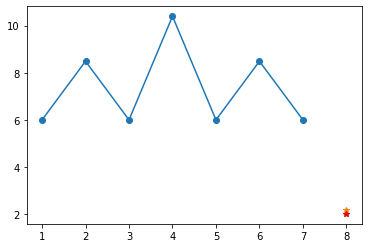

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

N_punto = np.arange(1,df1.shape[0]-2,1)

Dist=np.zeros(X_init.shape[0]-2)

#print(N_punto.shape)
for k in (N_punto):
          #print(k)
          Dist[k-1]=np.sqrt(np.sum((X_init[k,:]-X_init[k-1,:])**2))

print(N_punto)    
print(Dist)


plt.plot(N_punto,Dist,'-o')
plt.plot(max(N_punto)+1,np.sqrt(np.sum((X_init[-1,:]-x_EI_max)**2)),'*')
plt.plot(max(N_punto)+1,np.sqrt(np.sum((X_init[-1,:]-x_PI_max)**2)),'*',color='green')
plt.plot(max(N_punto)+1,np.sqrt(np.sum((X_init[-1,:]-x_UCB2_max)**2)),'*',color='red')